In [1]:
import warnings
warnings.filterwarnings("ignore")
from zigzag import *
from tqdm import tqdm
import talib
from sklearn.linear_model import LinearRegression
import statistics
import pandas as pd
#Show all columns
pd.set_option('display.max_columns', None)
#show all rows
pd.set_option('display.max_rows', None)
#show values with 100 digits
pd.set_option('max_colwidth',100)
import matplotlib.pyplot as plt
import plotly
import plotly.offline as py
import numpy as np
from backtesting import Backtest, Strategy
from IPython.display import clear_output
from gm.api import *
set_token('')

C:\Users\budin\Desktop\深度学习期货\螺纹钢\5分钟


Loading BokehJS ...

# Download Data

In [2]:
train_start = '2018-08-01'
train_ends = '2021-09-01'
train_df = history(symbol='SHFE.RB', frequency='300s', start_time=train_start, end_time=train_ends, 
                  fields='symbol, eob, frequency, open, close, high, low, amount, volume, position', 
                  skip_suspended=True, fill_missing=None, adjust=ADJUST_NONE, df=True)
train_df.to_json(path+'RB_5min_train.json')

train_df.shape, train_df.head(5), train_df.tail(5), train_df.dtypes

((49855, 10),
     symbol                       eob frequency    open   close    high  \
 0  SHFE.RB 2018-08-01 09:05:00+08:00      300s  4188.0  4189.0  4192.0   
 1  SHFE.RB 2018-08-01 09:10:00+08:00      300s  4189.0  4189.0  4195.0   
 2  SHFE.RB 2018-08-01 09:15:00+08:00      300s  4190.0  4206.0  4207.0   
 3  SHFE.RB 2018-08-01 09:20:00+08:00      300s  4205.0  4215.0  4217.0   
 4  SHFE.RB 2018-08-01 09:25:00+08:00      300s  4214.0  4221.0  4222.0   
 
       low      amount  volume  position  
 0  4184.0  2.4956e+09   59598   2782626  
 1  4187.0  2.0664e+09   49298   2779462  
 2  4189.0  4.4764e+09  106600   2780098  
 3  4199.0  5.5480e+09  131810   2783934  
 4  4210.0  3.6955e+09   87648   2786686  ,
         symbol                       eob frequency    open   close    high  \
 49850  SHFE.RB 2021-08-31 22:40:00+08:00      300s  5277.0  5275.0  5281.0   
 49851  SHFE.RB 2021-08-31 22:45:00+08:00      300s  5275.0  5272.0  5277.0   
 49852  SHFE.RB 2021-08-31 22:50:00+08

## Add Features

In [3]:
def add_indicators(result, column_list, rolling):
    keep = True
    for a in column_list:
        try:
            result[a] = result[a].values.astype('float64')
        except:
            keep = False
    if keep == True:
        unnormalized_close_array=result.close.values
        unnormalized_open_array=result.open.values
        result['pctChg']=result.close.pct_change()
        result.drop(result.head(1).index,inplace=True)
        #AR人气指标
        result['HO']=result.high-result.open
        result['OL']=result.open-result.low
        result['HCY']=result.high-result.close.shift(1)
        result['CYL']=result.close.shift(1)-result.low
        #计算AR、BR指标
        result['AR']=talib.SUM(result.HO, timeperiod=26)/talib.SUM(result.OL, timeperiod=26)*100
        result['BR']=talib.SUM(result.HCY, timeperiod=26)/talib.SUM(result.CYL, timeperiod=26)*100
        #资金流量
        result['today_money_flow'] = (result['close'] + result['high'] + result['low'])/3*result['volume']
        result['money_flow_KAMA_5'] = talib.KAMA(result.today_money_flow.values, timeperiod=5)
        result['money_flow_KAMA_13'] = talib.KAMA(result.today_money_flow.values, timeperiod=13)
        result['money_flow_KAMA_34'] = talib.KAMA(result.today_money_flow.values, timeperiod=34)       
        # 均幅指标（Average TRUE Ranger）显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
        result['ATR5'] = talib.ATR(result.high.values, result.low.values, result.close.values, timeperiod=5)
        result['ATR13'] = talib.ATR(result.high.values, result.low.values, result.close.values, timeperiod=13)
        result['ATR34'] = talib.ATR(result.high.values, result.low.values, result.close.values, timeperiod=34)
        # KAMA 适应性移动平均线(收盘价)
        result['KAMA_5'] = talib.KAMA(result.close.values, timeperiod=5)
        result['KAMA_13'] = talib.KAMA(result.close.values, timeperiod=13)
        result['KAMA_34'] = talib.KAMA(result.close.values, timeperiod=34)
        # KAMA 适应性移动平均线(成交量)
        result['KAMA_5'] = talib.KAMA(result.volume.values, timeperiod=5)
        result['KAMA_13'] = talib.KAMA(result.volume.values, timeperiod=13)
        result['KAMA_34'] = talib.KAMA(result.volume.values, timeperiod=34)
        # KAMA 适应性移动平均线(成交额)
        result['KAMA_5'] = talib.KAMA(result.amount.values, timeperiod=5)
        result['KAMA_13'] = talib.KAMA(result.amount.values, timeperiod=13)
        result['KAMA_34'] = talib.KAMA(result.amount.values, timeperiod=34)     
        # MACD
        result['MACD_DIF'], result['MACD_DEA'], result['MACD_bar'] = talib.MACD(result.close.values, fastperiod=12, slowperiod=24,
                                                                                signalperiod=9)
        # 顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
        result['CCI5'] = talib.CCI(result.high.values, result.low.values, result.close.values, timeperiod=5)
        result['CCI13'] = talib.CCI(result.high.values, result.low.values, result.close.values, timeperiod=13)
        result['CCI34'] = talib.CCI(result.high.values, result.low.values, result.close.values, timeperiod=34)
        #资金流指数（Money Flow Index）
        result['MFI_5'] = talib.MFI(result.high, result.low, result.close, result.volume, timeperiod=5)
        result['MFI_13'] = talib.MFI(result.high, result.low, result.close, result.volume, timeperiod=13)
        result['MFI_34'] = talib.MFI(result.high, result.low, result.close, result.volume, timeperiod=34)
        #收盘价动量指标（Momentum for Close Price）
        result['MOM_5_c'] = talib.MOM(result.close, timeperiod=5)
        result['MOM_13_c'] = talib.MOM(result.close, timeperiod=13)
        result['MOM_34_c'] = talib.MOM(result.close, timeperiod=34)
        #成交量动量指标（Momentum for Volume）
        result['MOM_5_v'] = talib.MOM(result.volume, timeperiod=5)
        result['MOM_13_v'] = talib.MOM(result.volume, timeperiod=13)
        result['MOM_34_v'] = talib.MOM(result.volume, timeperiod=34)
        #成交额动量指标（Momentum for Volume）
        result['MOM_5_a'] = talib.MOM(result.amount, timeperiod=5)
        result['MOM_13_a'] = talib.MOM(result.amount, timeperiod=13)
        result['MOM_34_a'] = talib.MOM(result.amount, timeperiod=34)
        
        result['BETA_5'] = talib.BETA(result.high, result.low, timeperiod=5)
        result['BETA_13'] = talib.BETA(result.high, result.low, timeperiod=13)
        result['BETA_34'] = talib.BETA(result.high, result.low, timeperiod=34)
        
        result['LINEARREG_ANGLE_5'] = talib.LINEARREG_ANGLE(result.close, timeperiod=5)
        result['LINEARREG_ANGLE_13'] = talib.LINEARREG_ANGLE(result.close, timeperiod=13)
        result['LINEARREG_ANGLE_34'] = talib.LINEARREG_ANGLE(result.close, timeperiod=34)
        
        result['LINEARREG_SLOPE_5'] = talib.LINEARREG_SLOPE(result.close, timeperiod=5)
        result['LINEARREG_SLOPE_13'] = talib.LINEARREG_SLOPE(result.close, timeperiod=13)
        result['LINEARREG_SLOPE_34'] = talib.LINEARREG_SLOPE(result.close, timeperiod=34)
        
        result.drop(result.head(35).index,inplace=True)
        result.fillna(method='ffill')
        
        columns = result.columns[3:].to_list()
        for i in columns:
            result[i] = (result[i]-result[i].rolling(window=rolling,center=False).mean())/\
                        result[i].rolling(window=rolling,center=False).std()
        result.dropna(inplace=True)
        diff = unnormalized_close_array.shape[0]-result.shape[0]
        result['unnormalized_close']=unnormalized_close_array[diff:]
        result['unnormalized_open']=unnormalized_open_array[diff:]
        result = result.reset_index(drop=True)
        print(result.shape)
        return result 
    
rolling_size = 60    
columns = ['open', 'close', 'high', 'low', 'amount', 'volume', 'position']
new_train_df = add_indicators(result=train_df.copy(), column_list=columns, rolling=rolling_size)
new_train_df.to_json(path+'RB_5min_processed_train.json')

new_train_df.shape, new_train_df.head(5), new_train_df.tail(5), new_train_df.dtypes

(49626, 56)


((49626, 56),
     symbol                       eob frequency    open   close    high  \
 0  SHFE.RB 2018-08-02 11:30:00+08:00      300s -0.9602 -0.8200 -0.9213   
 1  SHFE.RB 2018-08-02 13:35:00+08:00      300s -1.1320 -1.8628 -1.4425   
 2  SHFE.RB 2018-08-02 13:40:00+08:00      300s -1.9030 -2.2317 -2.2361   
 3  SHFE.RB 2018-08-02 13:45:00+08:00      300s -2.2069 -0.9740 -1.2344   
 4  SHFE.RB 2018-08-02 13:50:00+08:00      300s -0.9488 -0.5043 -0.4639   
 
       low  amount  volume  position  pctChg      HO      OL     HCY     CYL  \
 0 -0.6417 -0.6558 -0.6544   -1.2311  0.1235  0.3027 -1.1797 -0.1438 -0.6967   
 1 -1.8423  2.4421  2.4597   -1.1212 -2.4230 -0.9659  2.4631 -2.1108  3.0749   
 2 -2.3824  2.0328  2.0537   -1.5621 -0.7828 -0.9381  1.7084 -1.0713  1.6210   
 3 -1.9611  0.8549  0.8631   -1.6299  2.8514  3.4407 -0.7220  3.4319 -0.7044   
 4 -0.5577  1.4276  1.4291   -1.6165  1.0052  1.5480 -1.1329  1.5837 -1.0655   
 
        AR      BR  today_money_flow  money_flow_KAM

## Label Data

In [4]:
def plot_pivots(X, pivots):
    plt.figure(figsize=(16, 8))
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')
    #fig = plt.gcf()
    #plotly_fig = plotly.tools.mpl_to_plotly(fig)
    #py.iplot(plotly_fig)

## Check Data

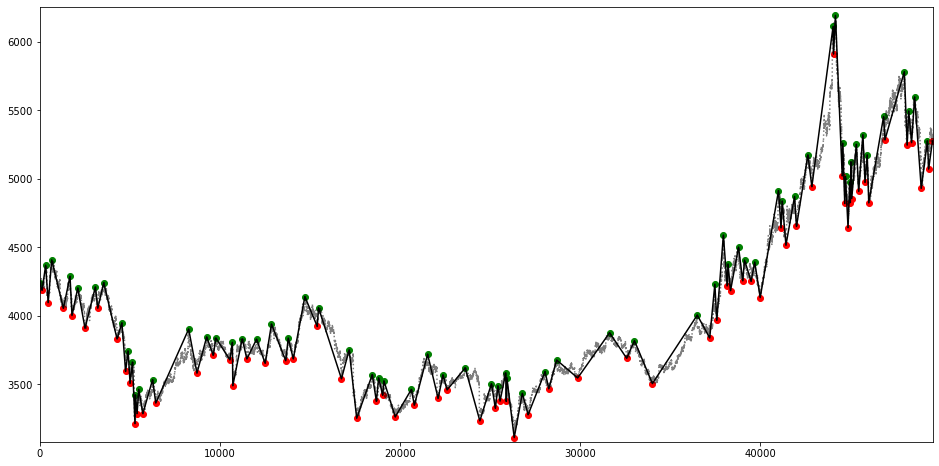

In [5]:
slippage_rate = (2/new_train_df.unnormalized_close.describe()['75%'])*2
commission_rate = 0.00015*2
mini_profit = 0.005
break_even = slippage_rate+commission_rate+mini_profit
label_interval = 0.03
close_values = new_train_df.unnormalized_close[rolling_size:].values.astype('float64')
pivots = peak_valley_pivots(close_values, label_interval, -label_interval)

plot_pivots(close_values, pivots)

In [6]:
np.min(np.abs(compute_segment_returns(close_values, pivots))), break_even, len(pivots)

(0.01297169811320753, 0.006245682368934334, 49566)

In [16]:
train_y = []
last_y_label = None
long_count = 0
short_count = 0
for i in tqdm(range(len(pivots))):
    tmp_x = pivots[i]
    #做空
    if tmp_x==1:
        train_y.append(0)
        last_y_label = 0
        long_count+=1
    #做多
    elif tmp_x==-1:
        train_y.append(1)
        last_y_label = 1
        short_count+=1
    else:
        train_y.append(last_y_label)
train_y = np.asarray(train_y)
np.save(path+'train_y.npy', train_y, allow_pickle=True)

train_y.shape, long_count, short_count

100%|████████████████████████████████████████████████████████████████████████| 49566/49566 [00:00<00:00, 990451.94it/s]


((49566,), 65, 66)

In [8]:
train_x = []
for i in tqdm(range(len(new_train_df.unnormalized_close.values)-rolling_size)):
    tmp_data = new_train_df.iloc[i:i+rolling_size].drop(columns=['symbol', 'eob', 'frequency', 'unnormalized_close', 'unnormalized_open'])
    train_x.append([tmp_data.values])
    
train_x = np.asarray(train_x)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[3])
np.save('train_x.npy', train_x)

train_x.shape

100%|██████████████████████████████████████████████████████████████████████████| 49566/49566 [00:16<00:00, 3054.73it/s]


(49566, 60, 51)

## Test Data's Labels

In [33]:
backtest_train_df = train_df.copy()
backtest_train_df.columns = ['symbol', 'eob', 'frequency', 'Open', 'Close', 'High', 'Low', 'Amount', 'Volume', 'position']
backtest_train_df.Open = backtest_train_df.Open*10
backtest_train_df.Close = backtest_train_df.Close*10
backtest_train_df.High = backtest_train_df.High*10
backtest_train_df.Low = backtest_train_df.Low*10
diff = len(backtest_train_df)-len(train_y)
backtest_train_df = backtest_train_df[diff:].reset_index(drop=True)
backtest_train_df['actions'] = train_y
market_data = backtest_train_df
mini_price_change = 2
slippage = 2*mini_price_change/market_data.Close.min()
commission_rate = slippage+0.00015

market_data.head(5), market_data.shape

(    symbol                       eob frequency     Open    Close     High  \
 0  SHFE.RB 2018-08-07 10:10:00+08:00      300s  42340.0  42400.0  42430.0   
 1  SHFE.RB 2018-08-07 10:15:00+08:00      300s  42400.0  42420.0  42450.0   
 2  SHFE.RB 2018-08-07 10:35:00+08:00      300s  42460.0  42500.0  42500.0   
 3  SHFE.RB 2018-08-07 10:40:00+08:00      300s  42500.0  42470.0  42520.0   
 4  SHFE.RB 2018-08-07 10:45:00+08:00      300s  42470.0  42630.0  42640.0   
 
        Low      Amount  Volume  position  actions  
 0  42330.0  8.9442e+08   21102   2271960        0  
 1  42380.0  8.9617e+08   21126   2269280        0  
 2  42420.0  8.1595e+08   19218   2269846        0  
 3  42460.0  6.6618e+08   15678   2268610        0  
 4  42470.0  2.7136e+09   63734   2278700        0  ,
 (49566, 11))

In [34]:
class backtest(Strategy):
    def init(self):
        price = self.data.Close
        self.action = self.data.actions
        self.index = 0
        self.flags = 0

    def next(self):
        actions = self.action[self.index]
        self.index += 1
        #做多
        if actions == 1:
            if self.flags == 0:
                self.buy()
                self.flags = 1
            elif self.flags == 1:
                pass
            else:
                self.buy()
                self.flags = 1
        #做空    
        elif actions == 0:
            if self.flags == 0:
                self.sell()
                self.flags = -1
            elif self.flags == 1:
                self.sell()
                self.flags = -1
            else:
                pass
bt = Backtest(market_data, backtest, cash=round(np.max(market_data.Close.max())*10*0.1/0.75), commission=commission_rate, margin=0.1, 
              trade_on_close=True, exclusive_orders=True)
stats = bt.run()
stats

Start                                       0
End                                 4.956e+04
Duration                            4.956e+04
Exposure Time [%]                         100
Equity Final [$]                    7.555e+30
Equity Peak [$]                     8.579e+30
Return [%]                           9.15e+27
Buy & Hold Return [%]                   24.46
Return (Ann.) [%]                           0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                                0
Max. Drawdown [%]                      -21.84
Avg. Drawdown [%]                      -2.894
Max. Drawdown Duration                    619
Avg. Drawdown Duration                  18.44
# Trades                                  130
Win Rate [%]                              100
Best Trade [%]                          22.97
Worst Trade [%]                         1.198
Avg. Trade [%]                    

In [35]:
bt.plot(smooth_equity=True,show_legend=False,plot_return=True, plot_equity=False)

Row(id='3380', ...)